<a href="https://colab.research.google.com/github/KaishvaShah/EE610_ImageProcessing/blob/main/Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment-3 for EE610(Image Processing)

## Question-1

For the first part we have to design a function that White Gaussian noise to images grayscale and RGB. It would take image and the variance as inputs. I will be using np.random.normal for this.

In [ ]:
import numpy as np

def awgn(img, var):
  noise = np.random.normal(0, var, img.shape)
  return img+noise

We can try out the function as follows

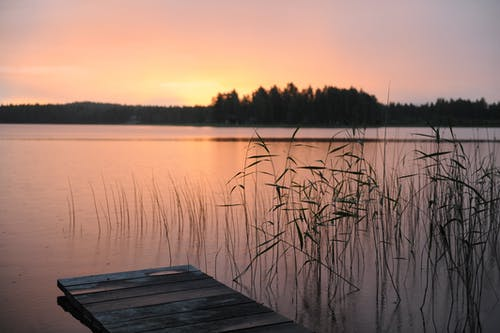

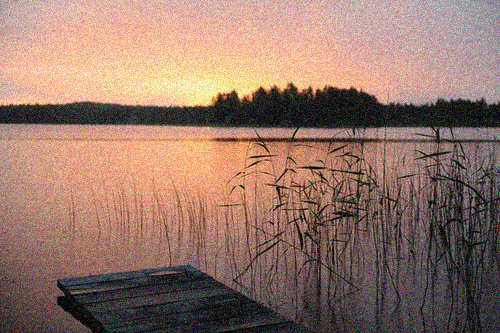

In [ ]:
import cv2
from google.colab.patches import cv2_imshow


img = cv2.imread("img.jpeg", cv2.IMREAD_COLOR)
cv2_imshow(img)
cv2_imshow(awgn(img,20))

For part-2 we have to make a function to calculate PSNR between a ground truth image and a restored image. We have to use maximum intensity level as 255 for the images. So PSNR is just 20log10(max intensity/RMSE)

In [ ]:
from math import log10, sqrt

def psnr(noisy, restored):
    mse = np.mean((noisy - restored) ** 2)
    max_pixel = 255.0
    return 20 * log10(max_pixel / sqrt(mse))

We can test it for the AWGN function defined earlier

In [ ]:
img_noise = awgn(img, 20)
psnr(img_noise, img)

22.12243399924645

For part-4 we have to define a function that implements gaussian blurring in images. The function can take variance and kernel size as inputs. It will then generate a Gaussian Distributon with those properties and convolve with the image


(333, 500, 3)
(333, 500, 3)


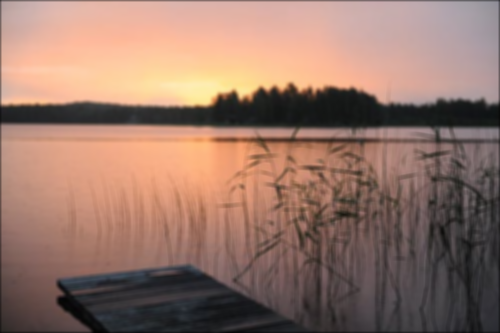

In [ ]:
from scipy import signal

def gauss_blur(img, size=5, var=5):
    ax = np.linspace(-(size - 1) / 2., (size - 1) / 2., size)
    xx, yy = np.meshgrid(ax, ax)

    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / var)
    kernel /= np.sum(kernel)

    row,col, layers = img.shape
    res = np.zeros(img.shape)

    for l in range(layers):
      res[:,:, l] = (signal.convolve2d(img[:,:,l], kernel, mode='same', boundary='fill', fillvalue=0))
    return res

cv2_imshow(gauss_blur(img))

Defining SSIM for part3

In [ ]:
import math
import numpy as np
import cv2

def ssim(img1, img2):
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()


def calculate_ssim(img1, img2):
    '''calculate SSIM
    the same outputs as MATLAB's
    img1, img2: [0, 255]
    '''
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    if img1.ndim == 2:
        return ssim(img1, img2)
    elif img1.ndim == 3:
        if img1.shape[2] == 3:
            ssims = []
            for i in range(3):
                ssims.append(ssim(img1, img2))
            return np.array(ssims).mean()
        elif img1.shape[2] == 1:
            return ssim(np.squeeze(img1), np.squeeze(img2))
    else:
        raise ValueError('Wrong input image dimensions.')

# Question-2

For the first part we need to define a function to set to zero any detail coefficient that is below a threshold.

We first take help of the library pywt https://pywavelets.readthedocs.io/en/latest/ to use their function dwt2 to be reused later.

In [5]:
import numpy as np
import matplotlib.pyplot as plt

import pywt
import pywt.data

def dwt(img):
  # Load image
  original = img

  # Wavelet transform of image, and plot approximation and details
  #titles = ['Approximation', ' Horizontal detail',
  #          'Vertical detail', 'Diagonal detail']
  coeffs2 = pywt.dwt2(original, 'haar')
  LL, (LH, HL, HH) = coeffs2
  return coeffs2
  #fig = plt.figure(figsize=(12, 3))
  #for i, a in enumerate([LL, LH, HL, HH]):
   #   ax = fig.add_subplot(1, 4, i + 1)
   #   ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
   #   ax.set_title(titles[i], fontsize=10)
   #   ax.set_xticks([])
   #   ax.set_yticks([])

  #fig.tight_layout()
  #plt.show()

Next we define the function for part 1

In [6]:
def hardt(img, t): # the arguments are image and threshold
  L=[]
  L[0], (L[1], L[2], L[3]) = dwt(img)
  for i in range(4):
    for x in L[i]:
      for y in L[i]:
        if(L[i][x,y]<t):
          L[i][x,y] = 0
      

Now we define the function for part2

In [7]:
def softt(img, t): # the arguments are image and threshold
  L=[]
  L[0], (L[1], L[2], L[3]) = dwt(img)
  for i in range(4):
    for x in L[i]:
      for y in L[i]:
        if(L[i][x,y]<t):
          L[i][x,y] = 0
        else:
          L[i][x,y] -= t